# 物理信息深度算子网络(PI-DeepONet)求解Burgers方程

本notebook实现了基于物理信息神经网络的深度算子网络，用于求解Burgers方程。
Burgers方程是一个重要的非线性偏微分方程，广泛应用于流体力学、交通流等领域。

方程形式：
$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$$

其中 $\nu = 1 \times 10^{-3}$ 是黏性系数。

## 1. 导入必要的库

导入PyTorch、NumPy、SciPy等必要的深度学习和科学计算库，为模型实现和数据处理做准备。

In [3]:
import torch
import torch.nn as nn

import os
import time
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

## 2. 定义梯度计算函数

实现自动微分函数，用于计算神经网络输出相对于输入的梯度，这是实现物理约束的关键组件。

In [4]:
def compute_gradient(outputs, inputs):
    """
    计算outputs相对于inputs的梯度
    
    Args:
        outputs: 神经网络的输出张量
        inputs: 输入张量
    
    Returns:
        梯度张量
    """
    return torch.autograd.grad(
        outputs, inputs, 
        grad_outputs=torch.ones_like(outputs),
        retain_graph=True, 
        create_graph=True
    )

## 3. 创建多层感知机(MLP)网络

定义标准的多层感知机类，包含可配置的隐藏层数、神经元数量，以及Xavier权重初始化方法。

In [5]:
class MultiLayerPerceptron(nn.Module):
    """
    多层感知机网络
    
    Args:
        input_dim: 输入维度
        output_dim: 输出维度
        hidden_dim: 隐藏层维度
        num_hidden_layers: 隐藏层数量
    """
    
    def __init__(self, input_dim, output_dim, hidden_dim, num_hidden_layers):
        super().__init__()

        # 构建网络结构
        layers = nn.Sequential()
        layers.add_module('input_layer', nn.Linear(input_dim, hidden_dim, bias=True))
        layers.add_module('input_activation', nn.Tanh())

        # 添加隐藏层
        for i in range(num_hidden_layers):
            layers.add_module(
                f'hidden_layer_{i+1}',
                nn.Linear(hidden_dim, hidden_dim, bias=True)
            )
            layers.add_module(f'hidden_activation_{i+1}', nn.Tanh())

        # 输出层
        layers.add_module('output_layer', nn.Linear(hidden_dim, output_dim, bias=True))

        self.model = layers
        self._initialize_weights()

    def _initialize_weights(self):
        """使用Xavier正态分布初始化权重"""
        for param in self.parameters():
            if len(param.shape) > 1:
                nn.init.xavier_normal_(param)

    def forward(self, x):
        return self.model(x)

## 4. 实现数据加载器类

创建专门的数据加载器，处理Burgers方程的训练数据，包括初始条件、边界条件和残差点的批量采样。

In [10]:
class BurgersDataLoader:
    """
    Burgers方程数据加载器
    
    Args:
        batch_size_residual: 残差点批量大小
        batch_size_initial: 初始条件点批量大小
        batch_size_boundary: 边界条件点批量大小
    """
    
    def __init__(self, batch_size_residual=10000, batch_size_initial=10000, batch_size_boundary=10000):
        self.batch_size_residual = batch_size_residual
        self.batch_size_boundary = batch_size_boundary
        self.batch_size_initial = batch_size_initial

        self._load_data()

    def _load_data(self):
        """加载Burgers方程数据集"""
        data = scipy.io.loadmat('/home/yc/DeepONet/PI-DeepONet/burger_nu_0.001.mat')
        gamma, initial_conditions, solutions, sig, tau, tspan = (
            data['gamma'], data['input'], data['output'], 
            data['sigma'], data['tau'], data['tspan']
        )

        # 创建时空网格 - 修正网格生成逻辑
        t_coords = np.linspace(0, 1, 101)
        x_coords = np.linspace(0, 1, 101)
        T, X = np.meshgrid(t_coords, x_coords, indexing='ij')
        self.mesh_points = np.concatenate([
            T.reshape(-1, 1), 
            X.reshape(-1, 1)
        ], axis=1)
        
        solutions = solutions.reshape(solutions.shape[0], -1, 1)

        # 训练数据分割
        num_train, num_test = 1000, 100
        self.initial_conditions_train = initial_conditions[:num_train, ...].reshape(num_train, 101)
        self.solutions_train = solutions[:num_train, ...].reshape(num_train, -1, 1)

        # 测试数据分割
        test_start_idx = 1600
        num_test_samples = 200
        test_indices = np.arange(test_start_idx, test_start_idx + num_test_samples)
        self.initial_conditions_test = initial_conditions[test_indices, ...].reshape(num_test_samples, 101)
        self.solutions_test = solutions[test_indices, ...].reshape(num_test_samples, -1, 1)

        # 保存其他参数
        self.gamma, self.tau, self.tspan = gamma, tau, tspan

    def get_residual_batch(self):
        """获取残差点批量数据"""
        # 随机选择初始条件
        ic_indices = np.random.randint(
            low=0, high=self.initial_conditions_train.shape[0], 
            size=(self.batch_size_residual,)
        )
        initial_conditions_batch = self.initial_conditions_train[ic_indices, ...].reshape(
            self.batch_size_residual, -1
        )

        # 随机选择时空点
        mesh_indices = np.random.randint(
            low=0, high=self.mesh_points.shape[0], 
            size=(self.batch_size_residual,)
        )
        mesh_batch = self.mesh_points[mesh_indices, :].reshape(-1, 2)
        
        return initial_conditions_batch, mesh_batch

    def get_boundary_batch(self):
        """获取边界条件批量数据"""
        # 随机选择初始条件
        ic_indices = np.random.randint(
            low=0, high=self.initial_conditions_train.shape[0], 
            size=(self.batch_size_boundary//2,)
        )
        initial_conditions_batch = self.initial_conditions_train[ic_indices, ...].reshape(
            self.batch_size_boundary//2, -1
        )

        # 生成边界点
        t_coords = np.random.uniform(
            low=0, high=1, size=(self.batch_size_boundary//2, 1)
        )
        x_left = np.zeros((self.batch_size_boundary//2, 1))
        x_right = np.ones((self.batch_size_boundary//2, 1))
        
        mesh_left = np.concatenate([t_coords, x_left], axis=1)
        mesh_right = np.concatenate([t_coords, x_right], axis=1)

        return initial_conditions_batch, mesh_left, mesh_right

    def get_initial_condition_batch(self):
        """获取初始条件批量数据"""
        # 随机选择初始条件
        ic_indices = np.random.randint(
            low=0, high=self.initial_conditions_train.shape[0], 
            size=(100,)
        )
        initial_conditions = self.initial_conditions_train[ic_indices, :].reshape(100, 101)
        solution_at_t0 = initial_conditions.reshape(-1, 1)
        
        # 重复初始条件以匹配空间点
        initial_conditions_expanded = np.repeat(initial_conditions, repeats=101, axis=0)
        
        # 创建初始时刻的空间网格
        x_coords = np.linspace(0, 1, 101).reshape(-1, 1)
        x_coords_tiled = np.tile(x_coords, (100, 1))
        t_coords_zero = np.zeros_like(x_coords_tiled)
        mesh_initial = np.concatenate([t_coords_zero, x_coords_tiled], axis=1)
        
        return initial_conditions_expanded, mesh_initial, solution_at_t0

    def __call__(self):
        """返回所有类型的批量数据"""
        initial_batch = self.get_initial_condition_batch()
        boundary_batch = self.get_boundary_batch()
        residual_batch = self.get_residual_batch()
        return initial_batch, residual_batch, boundary_batch

## 5. 构建DeepONet算子网络

实现DeepONet架构，包含分支网络(branch network)和主干网络(trunk network)，用于学习函数到函数的映射。

In [7]:
class DeepOperatorNetwork(nn.Module):
    """
    深度算子网络(DeepONet)用于求解Burgers方程
    
    DeepONet包含两个主要组件：
    - 分支网络(Branch Network): 处理函数输入(初始条件)
    - 主干网络(Trunk Network): 处理坐标输入(时空点)
    """
    
    def __init__(self):
        super().__init__()

        # 分支网络：处理初始条件 (输入维度101 -> 输出维度100)
        self.branch_network = MultiLayerPerceptron(
            input_dim=101, output_dim=100, 
            hidden_dim=100, num_hidden_layers=10
        )
        
        # 主干网络：处理时空坐标 (输入维度2 -> 输出维度100)
        self.trunk_network = MultiLayerPerceptron(
            input_dim=2, output_dim=100, 
            hidden_dim=100, num_hidden_layers=10
        )
        
        self.activation = nn.Tanh()

    def forward(self, initial_condition, mesh_coordinates):
        """
        前向传播
        
        Args:
            initial_condition: 初始条件 [batch_size, 101]
            mesh_coordinates: 时空坐标 [batch_size, 2]
        
        Returns:
            branch_output: 分支网络输出
            trunk_output: 主干网络输出
        """
        # 通过输入层
        branch_features = self.branch_network.model.input_layer(initial_condition)
        trunk_features = self.trunk_network.model.input_layer(mesh_coordinates)
    
        # 通过隐藏层 (仅使用前6层)
        for i in range(6):
            layer_name = f'hidden_layer_{i+1}'
            
            branch_features = self.activation(
                getattr(self.branch_network.model, layer_name)(branch_features)
            )
            trunk_features = self.activation(
                getattr(self.trunk_network.model, layer_name)(trunk_features)
            )
        
        # 输出层
        branch_output = self.branch_network.model.output_layer(branch_features)
        trunk_output = self.trunk_network.model.output_layer(trunk_features)
        
        return branch_output, trunk_output

## 6. 实现物理信息深度算子网络(PI-DeepONet)

构建完整的PI-DeepONet类，集成物理约束损失函数、优化器配置和训练循环管理。

In [8]:
class PhysicsInformedDeepONet:
    """
    物理信息深度算子网络(PI-DeepONet)
    
    集成物理约束、损失函数和训练流程的完整框架
    """
    
    def __init__(self):
        # 设备配置
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"使用设备: {self.device}")

        # 初始化网络
        self.deeponet = DeepOperatorNetwork()
        self.deeponet.zero_grad()
        self.deeponet.to(self.device)

        # 优化器设置
        self.optimizer = torch.optim.Adam(self.deeponet.parameters(), lr=1e-3)
        self.lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
            self.optimizer, gamma=0.9, verbose=True
        )

        # 数据加载器
        self.data_loader = BurgersDataLoader()

        # 损失记录
        self.total_loss_history = []
        self.residual_loss_history = []
        self.initial_loss_history = []
        self.boundary_loss_history = []

    def _convert_to_device(self, initial_condition, mesh_coordinates, solution=None):
        """将数据转换到指定设备"""
        initial_condition = torch.tensor(
            initial_condition, dtype=torch.float32, device=self.device
        )
        mesh_coordinates = torch.tensor(
            mesh_coordinates, dtype=torch.float32, device=self.device
        )
        
        if solution is not None:
            solution = torch.tensor(
                solution, dtype=torch.float32, device=self.device
            )
            return initial_condition, mesh_coordinates, solution
        else:
            return initial_condition, mesh_coordinates

    def _operator_network_prediction(self, initial_condition, t_coords, x_coords):
        """
        使用算子网络进行预测
        
        Args:
            initial_condition: 初始条件
            t_coords: 时间坐标
            x_coords: 空间坐标
        
        Returns:
            预测的解
        """
        # 启用自动微分
        initial_condition.requires_grad_(True)
        t_coords.requires_grad_(True)
        x_coords.requires_grad_(True)
        
        # 前向传播
        branch_output, trunk_output = self.deeponet(
            initial_condition, torch.cat([t_coords, x_coords], dim=1)
        )
        
        # 计算最终输出 (点积)
        solution = torch.sum(torch.mul(branch_output, trunk_output), dim=1).reshape(-1, 1)
        return solution

    def _compute_residual(self, initial_condition, t_coords, x_coords):
        """
        计算Burgers方程的残差
        
        Burgers方程: ∂u/∂t + u * ∂u/∂x - ν * ∂²u/∂x² = 0
        其中 ν = 1e-3
        """
        solution = self._operator_network_prediction(initial_condition, t_coords, x_coords)
        
        # 计算一阶和二阶导数
        solution_t = compute_gradient(solution, t_coords)[0]
        solution_x = compute_gradient(solution, x_coords)[0]
        solution_xx = compute_gradient(solution_x, x_coords)[0]

        # Burgers方程残差
        residual = solution_t + solution * solution_x - 1e-3 * solution_xx
        return residual

    def compute_residual_loss(self, residual_batch):
        """计算残差损失"""
        initial_condition, mesh_coordinates = residual_batch
        initial_condition, mesh_coordinates = self._convert_to_device(
            initial_condition, mesh_coordinates
        )
        
        residual = self._compute_residual(
            initial_condition, mesh_coordinates[:, 0:1], mesh_coordinates[:, 1:2]
        )
        loss = torch.mean(residual**2)
        return loss

    def compute_boundary_loss(self, boundary_batch):
        """计算边界条件损失(周期性边界条件)"""
        initial_condition, mesh_left, mesh_right = boundary_batch
        initial_condition, mesh_left, mesh_right = self._convert_to_device(
            initial_condition, mesh_left, mesh_right
        )
        
        # 左边界预测
        t_left, x_left = mesh_left[:, 0:1], mesh_left[:, 1:2]
        solution_left = self._operator_network_prediction(initial_condition, t_left, x_left)
        solution_left_x = compute_gradient(solution_left, x_left)[0]
        
        # 右边界预测
        t_right, x_right = mesh_right[:, 0:1], mesh_right[:, 1:2]
        solution_right = self._operator_network_prediction(initial_condition, t_right, x_right)
        solution_right_x = compute_gradient(solution_right, x_right)[0]
        
        # 周期性边界条件：u(0,t) = u(1,t) 和 ∂u/∂x(0,t) = ∂u/∂x(1,t)
        loss = (
            torch.mean((solution_left - solution_right)**2) + 
            torch.mean((solution_left_x - solution_right_x)**2)
        )
        return loss

    def compute_initial_condition_loss(self, initial_batch):
        """计算初始条件损失"""
        initial_condition, mesh_coordinates, true_solution = initial_batch
        initial_condition, mesh_coordinates, true_solution = self._convert_to_device(
            initial_condition, mesh_coordinates, true_solution
        )
        
        predicted_solution = self._operator_network_prediction(
            initial_condition, mesh_coordinates[:, 0:1], mesh_coordinates[:, 1:2]
        )
        loss = torch.mean((predicted_solution - true_solution)**2)
        return loss

    def compute_relative_l2_error(self, sample_index=4):
        """计算相对L2误差"""
        # 切换到评估模式
        self.deeponet.eval()
        
        with torch.no_grad():
            initial_condition = self.data_loader.initial_conditions_test[sample_index, ...].reshape(1, -1)
            mesh_coordinates = self.data_loader.mesh_points
            initial_condition_tiled = np.tile(initial_condition, (mesh_coordinates.shape[0], 1))
            true_solution = self.data_loader.solutions_test[sample_index, ...].reshape(-1, 1)
            
            initial_condition_tiled, mesh_coordinates = self._convert_to_device(
                initial_condition_tiled, mesh_coordinates
            )
            
            # 需要重新启用梯度计算用于网络预测
            initial_condition_tiled.requires_grad_(True)
            mesh_coordinates.requires_grad_(True)
            
            predicted_solution = self._operator_network_prediction(
                initial_condition_tiled, mesh_coordinates[:, 0:1], mesh_coordinates[:, 1:2]
            )
            predicted_solution = predicted_solution.detach().cpu().numpy()
            
            relative_error = (
                np.linalg.norm(predicted_solution - true_solution, 2) / 
                np.linalg.norm(true_solution, 2)
            )
        
        # 切换回训练模式
        self.deeponet.train()
        
        print(f'相对L2误差: {relative_error:.3e}')
        return relative_error

    def _training_step(self, initial_batch, residual_batch, boundary_batch):
        """执行一步训练"""
        self.optimizer.zero_grad()
        
        # 计算各项损失
        initial_loss = self.compute_initial_condition_loss(initial_batch)
        residual_loss = self.compute_residual_loss(residual_batch)
        boundary_loss = self.compute_boundary_loss(boundary_batch)
        
        # 总损失
        total_loss = initial_loss + residual_loss + boundary_loss
        
        # 反向传播
        total_loss.backward()
        self.optimizer.step()
        
        return (
            total_loss.item(), initial_loss.item(), 
            residual_loss.item(), boundary_loss.item()
        )

    def train(self, num_iterations=120000, lr_decay_steps=2000):
        """训练模型"""
        print("开始训练...")
        # 确保模型处于训练模式
        self.deeponet.train()
        
        start_time = time.time()

        for iteration in range(1, num_iterations + 1):
            # 获取批量数据
            initial_batch, residual_batch, boundary_batch = self.data_loader()
            
            # 执行训练步骤
            total_loss, initial_loss, residual_loss, boundary_loss = self._training_step(
                initial_batch, residual_batch, boundary_batch
            )

            # 记录损失
            if iteration % 100 == 0:
                self.total_loss_history.append(total_loss)
                self.initial_loss_history.append(initial_loss)
                self.residual_loss_history.append(residual_loss)
                self.boundary_loss_history.append(boundary_loss)
                
                print(
                    f'迭代 {iteration}: '
                    f'初始条件损失 {initial_loss:.3e}, '
                    f'残差损失 {residual_loss:.3e}, '
                    f'边界损失 {boundary_loss:.3e}'
                )

            # 计算L2误差
            if iteration % 1000 == 0:
                self.compute_relative_l2_error()

            # 学习率衰减
            if iteration % lr_decay_steps == 0:
                self.lr_scheduler.step()

        end_time = time.time()
        print(f'训练完成，耗时: {end_time - start_time:.4f} 秒')

## 7. 训练模型

执行模型训练过程，包括损失函数监控、学习率调度和周期性性能评估。

In [7]:
# 创建训练器并开始训练
trainer = PhysicsInformedDeepONet()
trainer.train()

使用设备: cuda


/home/yc/miniconda3/envs/IFact/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


开始训练...
迭代 100: 初始条件损失 4.193e-02, 残差损失 4.126e-05, 边界损失 9.990e-04
迭代 100: 初始条件损失 4.193e-02, 残差损失 4.126e-05, 边界损失 9.990e-04
迭代 200: 初始条件损失 4.244e-02, 残差损失 2.460e-04, 边界损失 1.801e-03
迭代 200: 初始条件损失 4.244e-02, 残差损失 2.460e-04, 边界损失 1.801e-03
迭代 300: 初始条件损失 4.168e-02, 残差损失 5.435e-04, 边界损失 1.357e-03
迭代 300: 初始条件损失 4.168e-02, 残差损失 5.435e-04, 边界损失 1.357e-03
迭代 400: 初始条件损失 3.853e-02, 残差损失 5.885e-04, 边界损失 8.961e-04
迭代 400: 初始条件损失 3.853e-02, 残差损失 5.885e-04, 边界损失 8.961e-04
迭代 500: 初始条件损失 3.589e-02, 残差损失 6.650e-04, 边界损失 1.848e-03
迭代 500: 初始条件损失 3.589e-02, 残差损失 6.650e-04, 边界损失 1.848e-03
迭代 600: 初始条件损失 4.146e-02, 残差损失 6.832e-04, 边界损失 1.255e-03
迭代 600: 初始条件损失 4.146e-02, 残差损失 6.832e-04, 边界损失 1.255e-03
迭代 700: 初始条件损失 3.790e-02, 残差损失 7.346e-04, 边界损失 1.595e-03
迭代 700: 初始条件损失 3.790e-02, 残差损失 7.346e-04, 边界损失 1.595e-03
迭代 800: 初始条件损失 4.154e-02, 残差损失 1.894e-04, 边界损失 1.181e-03
迭代 800: 初始条件损失 4.154e-02, 残差损失 1.894e-04, 边界损失 1.181e-03
迭代 900: 初始条件损失 3.907e-02, 残差损失 8.094e-04, 边界损失 2.098e-03
迭代 900: 初始条件损失 3.907e-0

## 8. 保存训练结果和模型

将训练过程中的损失历史和训练好的模型参数保存到文件，便于后续分析和使用。

In [8]:
# 创建保存目录
save_dir = './pi_deeponet_results/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"创建保存目录: {save_dir}")

# 保存损失历史
initial_loss_array = np.array(trainer.initial_loss_history).reshape(-1, 1)
residual_loss_array = np.array(trainer.residual_loss_history).reshape(-1, 1)
boundary_loss_array = np.array(trainer.boundary_loss_history).reshape(-1, 1)
iterations_array = np.arange(100, 120100, 100).reshape(-1, 1)

loss_history = np.concatenate([
    iterations_array, initial_loss_array, 
    residual_loss_array, boundary_loss_array
], axis=1)

np.save(os.path.join(save_dir, 'loss_history.npy'), loss_history)
print("损失历史已保存")

# 保存模型权重
model_state = {'state_dict': trainer.deeponet.state_dict()}
torch.save(model_state, os.path.join(save_dir, 'deeponet_model.pth'))
print("模型权重已保存")

创建保存目录: ./pi_deeponet_results/
损失历史已保存
模型权重已保存


## 9. 计算测试集性能指标

在测试集上评估模型性能，计算L2相对误差的统计指标(均值、标准差、最大值)。

In [ ]:
# Calculate L2 errors for all test samples
trainer.deeponet.eval()  # Set to evaluation mode

l2_errors = []
num_test_samples = trainer.data_loader.initial_conditions_test.shape[0]

print(f"Evaluating {num_test_samples} test samples...")

with torch.no_grad():
    for k in range(num_test_samples):
        initial_condition = trainer.data_loader.initial_conditions_test[k, ...].reshape(1, -1)
        mesh_coordinates = trainer.data_loader.mesh_points
        initial_condition_tiled = np.tile(initial_condition, (mesh_coordinates.shape[0], 1))
        true_solution = trainer.data_loader.solutions_test[k, ...].reshape(-1, 1)
            
        initial_condition_tiled, mesh_coordinates = trainer._convert_to_device(
            initial_condition_tiled, mesh_coordinates
        )
        
        # Enable gradients for network prediction
        initial_condition_tiled.requires_grad_(True)
        mesh_coordinates.requires_grad_(True)
        
        predicted_solution = trainer._operator_network_prediction(
            initial_condition_tiled, mesh_coordinates[:, 0:1], mesh_coordinates[:, 1:2]
        )
        predicted_solution = predicted_solution.detach().cpu().numpy()
        
        relative_error = (
            np.linalg.norm(predicted_solution - true_solution, 2) / 
            np.linalg.norm(true_solution, 2)
        )
        l2_errors.append(relative_error)

l2_errors = np.array(l2_errors).reshape(-1, 1)

# Calculate statistics
l2_mean = l2_errors.mean()
l2_std = l2_errors.std()
l2_max = l2_errors.max()

print(f'\nTest Set Performance Statistics ({num_test_samples} samples):')
print(f'L2 Relative Error - Mean: {l2_mean:.3e}, Std: {l2_std:.3e}, Max: {l2_max:.3e}')

trainer.deeponet.train()  # Reset to training mode

正在评估 200 个测试样本...

测试集性能统计 (200 样本):
L2相对误差 - 均值: 2.859e-01, 标准差: 1.228e-01, 最大值: 5.701e-01

测试集性能统计 (200 样本):
L2相对误差 - 均值: 2.859e-01, 标准差: 1.228e-01, 最大值: 5.701e-01


## 10. 加载预训练模型进行测试

重新加载已训练的模型权重，准备在新的测试数据上进行评估。

In [11]:
# Create new trainer and load pretrained model
test_trainer = PhysicsInformedDeepONet()
model_checkpoint = torch.load('./pi_deeponet_results/deeponet_model.pth')
test_trainer.deeponet.load_state_dict(model_checkpoint['state_dict'])
print("Pretrained model loaded successfully")

使用设备: cuda
Pretrained model loaded successfully


/tmp/ipykernel_3513904/135104894.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_checkpoint = torch.load('./pi_deeponet_results/deeponet_model.pth')


## 11. 在更大测试集上评估性能

使用包含1000个样本的扩展测试集，全面评估模型的泛化能力和预测精度。

In [12]:
# Load complete dataset
data = scipy.io.loadmat('/home/yc/DeepONet/PI-DeepONet/burger_nu_0.001.mat')
gamma, initial_conditions, solutions, sig, tau, tspan = (
    data['gamma'], data['input'], data['output'], 
    data['sigma'], data['tau'], data['tspan']
)

# Create spatiotemporal grid - corrected grid generation logic
t_coords = np.linspace(0, 1, 101)
x_coords = np.linspace(0, 1, 101)
T, X = np.meshgrid(t_coords, x_coords, indexing='ij')
mesh_coordinates = np.concatenate([
    T.reshape(-1, 1), 
    X.reshape(-1, 1)
], axis=1)
solutions = solutions.reshape(solutions.shape[0], -1, 1)

# Use larger test set (1000 samples)
extended_test_initial_conditions = initial_conditions[1000:, ...].reshape(1000, 101)
extended_test_solutions = solutions[1000:, ...].reshape(1000, -1, 1)

# Update test data
test_trainer.data_loader.initial_conditions_test = extended_test_initial_conditions
test_trainer.data_loader.solutions_test = extended_test_solutions

print("Extended test set prepared (1000 samples)")

Extended test set prepared (1000 samples)


In [13]:
# Evaluate performance on extended test set
test_trainer.deeponet.eval()  # Set to evaluation mode

extended_l2_errors = []
num_extended_samples = test_trainer.data_loader.initial_conditions_test.shape[0]

print(f"Evaluating extended test set ({num_extended_samples} samples)...")

with torch.no_grad():
    for k in range(num_extended_samples):
        initial_condition = test_trainer.data_loader.initial_conditions_test[k, ...].reshape(1, -1)
        mesh_coords = test_trainer.data_loader.mesh_points
        initial_condition_tiled = np.tile(initial_condition, (mesh_coords.shape[0], 1))
        true_solution = test_trainer.data_loader.solutions_test[k, ...].reshape(-1, 1)
            
        initial_condition_tiled, mesh_coords = test_trainer._convert_to_device(
            initial_condition_tiled, mesh_coords
        )
        
        # Enable gradients for network prediction
        initial_condition_tiled.requires_grad_(True)
        mesh_coords.requires_grad_(True)
        
        predicted_solution = test_trainer._operator_network_prediction(
            initial_condition_tiled, mesh_coords[:, 0:1], mesh_coords[:, 1:2]
        )
        predicted_solution = predicted_solution.detach().cpu().numpy()
        
        relative_error = (
            np.linalg.norm(predicted_solution - true_solution, 2) / 
            np.linalg.norm(true_solution, 2)
        )
        extended_l2_errors.append(relative_error)

extended_l2_errors = np.array(extended_l2_errors).reshape(-1, 1)

# Calculate extended test set statistics
extended_l2_mean = extended_l2_errors.mean()
extended_l2_std = extended_l2_errors.std()
extended_l2_max = extended_l2_errors.max()

print(f'\nExtended Test Set Performance Statistics ({num_extended_samples} samples):')
print(f'L2 Relative Error - Mean: {extended_l2_mean:.3e}, Std: {extended_l2_std:.3e}, Max: {extended_l2_max:.3e}')

test_trainer.deeponet.train()  # Reset to training mode

Evaluating extended test set (1000 samples)...

Extended Test Set Performance Statistics (1000 samples):
L2 Relative Error - Mean: 2.797e-01, Std: 1.214e-01, Max: 8.707e-01


DeepOperatorNetwork(
  (branch_network): MultiLayerPerceptron(
    (model): Sequential(
      (input_layer): Linear(in_features=101, out_features=100, bias=True)
      (input_activation): Tanh()
      (hidden_layer_1): Linear(in_features=100, out_features=100, bias=True)
      (hidden_activation_1): Tanh()
      (hidden_layer_2): Linear(in_features=100, out_features=100, bias=True)
      (hidden_activation_2): Tanh()
      (hidden_layer_3): Linear(in_features=100, out_features=100, bias=True)
      (hidden_activation_3): Tanh()
      (hidden_layer_4): Linear(in_features=100, out_features=100, bias=True)
      (hidden_activation_4): Tanh()
      (hidden_layer_5): Linear(in_features=100, out_features=100, bias=True)
      (hidden_activation_5): Tanh()
      (hidden_layer_6): Linear(in_features=100, out_features=100, bias=True)
      (hidden_activation_6): Tanh()
      (hidden_layer_7): Linear(in_features=100, out_features=100, bias=True)
      (hidden_activation_7): Tanh()
      (hidden_

## 12. 可视化预测结果

定义可视化函数，生成真实解、预测解和绝对误差的对比图，直观展示模型性能。

In [16]:
def visualize_prediction_comparison(trainer, sample_index):
    """
    Visualize prediction comparison
    
    Args:
        trainer: Trainer object
        sample_index: Test sample index
    """
    # Set model to evaluation mode
    trainer.deeponet.eval()
    
    with torch.no_grad():
        # Prepare data
        initial_condition = trainer.data_loader.initial_conditions_test[sample_index, ...].reshape(1, -1)
        mesh_coordinates = trainer.data_loader.mesh_points
        initial_condition_tiled = np.tile(initial_condition, (mesh_coordinates.shape[0], 1))
        true_solution = trainer.data_loader.solutions_test[sample_index, ...].reshape(-1, 1)
            
        initial_condition_tiled, mesh_coordinates = trainer._convert_to_device(
            initial_condition_tiled, mesh_coordinates
        )
        
        # Enable gradients for network prediction
        initial_condition_tiled.requires_grad_(True)
        mesh_coordinates.requires_grad_(True)
        
        # Prediction
        predicted_solution = trainer._operator_network_prediction(
            initial_condition_tiled, mesh_coordinates[:, 0:1], mesh_coordinates[:, 1:2]
        )
        predicted_solution = predicted_solution.detach().cpu().numpy()
        mesh_coordinates = mesh_coordinates.detach().cpu().numpy()
        
        # Calculate relative error
        relative_error = (
            np.linalg.norm(true_solution - predicted_solution, 2) / 
            np.linalg.norm(true_solution, 2)
        )
        print(f'Sample {sample_index} Relative L2 Error: {relative_error:.3e}')
        
        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Reshape solutions for visualization (101x101 grid)
        # The mesh points are organized as (t, x) pairs
        true_solution_2d = true_solution.reshape(101, 101)
        predicted_solution_2d = predicted_solution.reshape(101, 101)
        absolute_error_2d = np.abs(predicted_solution - true_solution).reshape(101, 101)
        
        # Create coordinate grids
        t_coords = np.linspace(0, 1, 101)
        x_coords = np.linspace(0, 1, 101)
        
        # Find common color limits for better comparison
        vmin = min(true_solution.min(), predicted_solution.min())
        vmax = max(true_solution.max(), predicted_solution.max())
        
        # True solution
        im1 = axes[0].imshow(true_solution_2d.T, extent=[0, 1, 0, 1], 
                            origin='lower', aspect='equal', cmap='jet', vmin=vmin, vmax=vmax)
        axes[0].set_xlabel('Time t')
        axes[0].set_ylabel('Space x')
        axes[0].set_title('True Solution')
        plt.colorbar(im1, ax=axes[0], shrink=0.8)
        
        # Predicted solution
        im2 = axes[1].imshow(predicted_solution_2d.T, extent=[0, 1, 0, 1], 
                            origin='lower', aspect='equal', cmap='jet', vmin=vmin, vmax=vmax)
        axes[1].set_xlabel('Time t')
        axes[1].set_ylabel('Space x')
        axes[1].set_title('Predicted Solution')
        plt.colorbar(im2, ax=axes[1], shrink=0.8)
        
        # Absolute error
        im3 = axes[2].imshow(absolute_error_2d.T, extent=[0, 1, 0, 1], 
                            origin='lower', aspect='equal', cmap='jet')
        axes[2].set_xlabel('Time t')
        axes[2].set_ylabel('Space x')
        axes[2].set_title('Absolute Error')
        plt.colorbar(im3, ax=axes[2], shrink=0.8)
        
        plt.tight_layout()
        plt.show()
    
    # Reset to training mode
    trainer.deeponet.train()

## 13. 绘制多个测试样本的预测对比

选择多个具有代表性的测试样本，展示模型在不同初始条件下的预测效果和误差分布。

Generating prediction result visualizations...


=== Test Sample 2 ===
Sample 2 Relative L2 Error: 1.919e-01


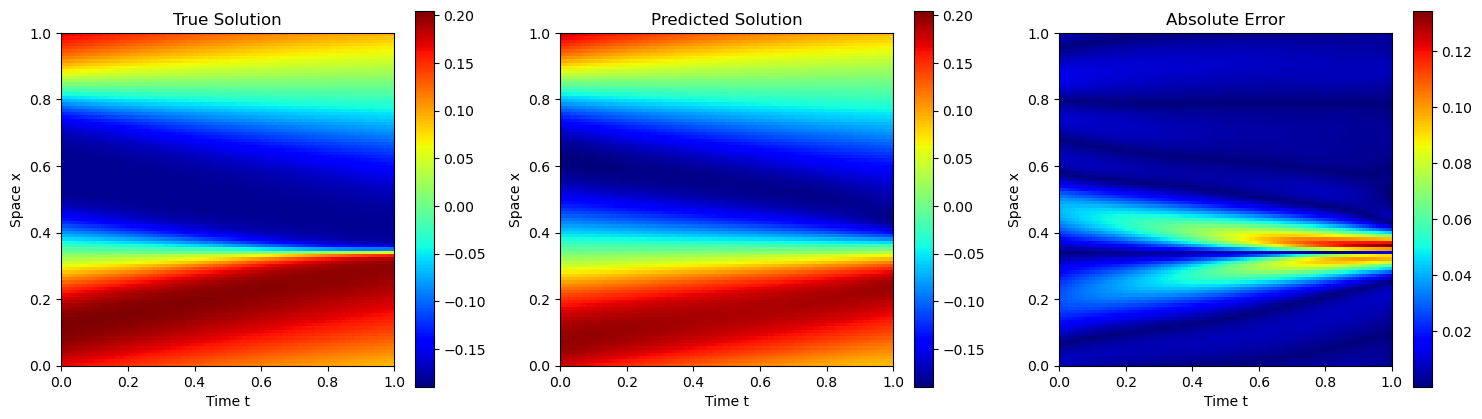


=== Test Sample 4 ===
Sample 4 Relative L2 Error: 3.774e-01


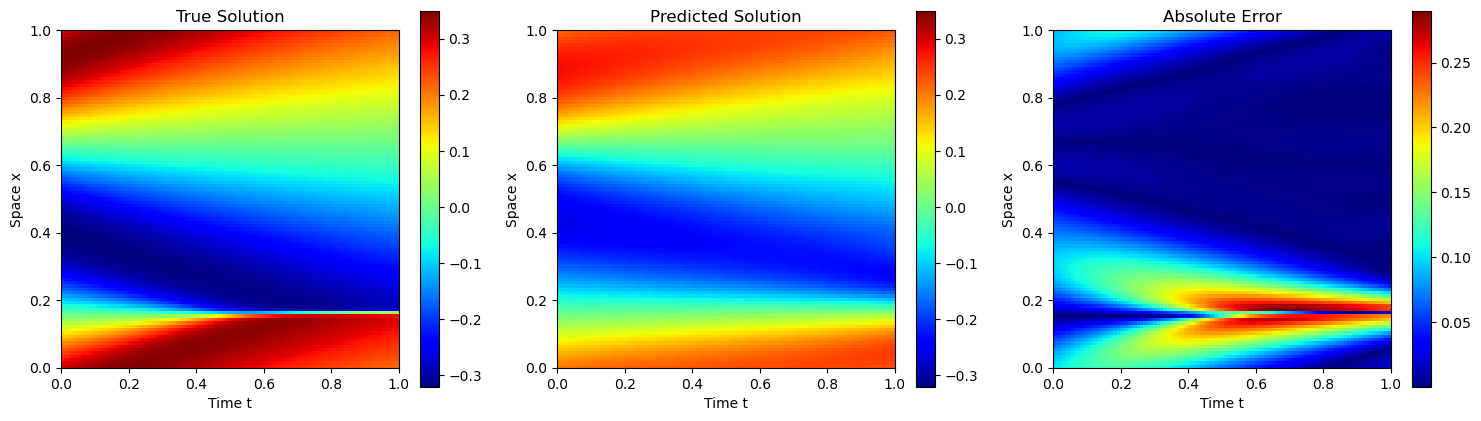


=== Test Sample 8 ===
Sample 8 Relative L2 Error: 2.945e-01


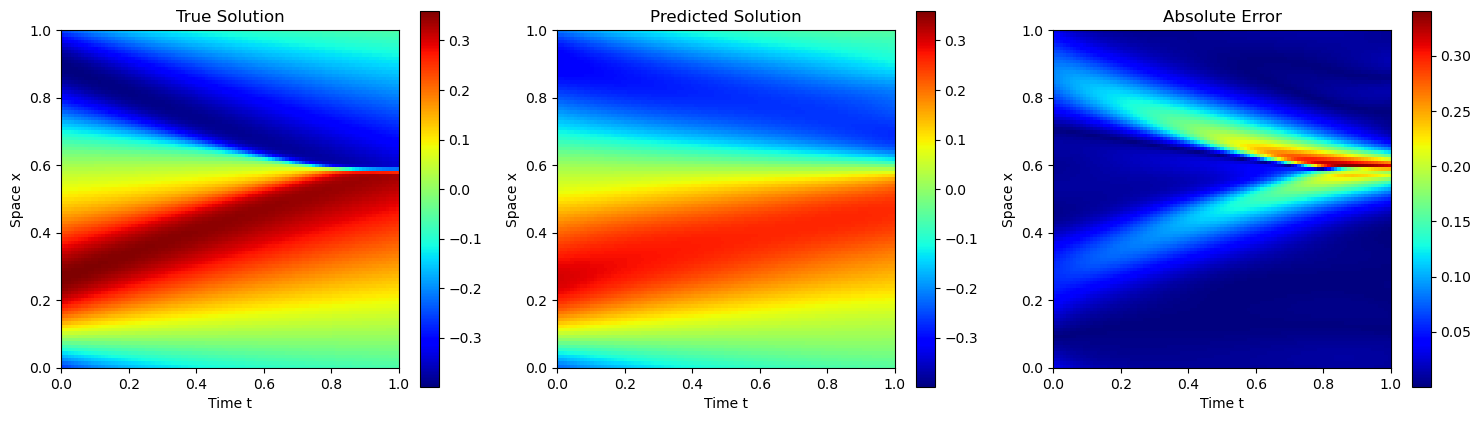


=== Test Sample 10 ===
Sample 10 Relative L2 Error: 3.430e-01


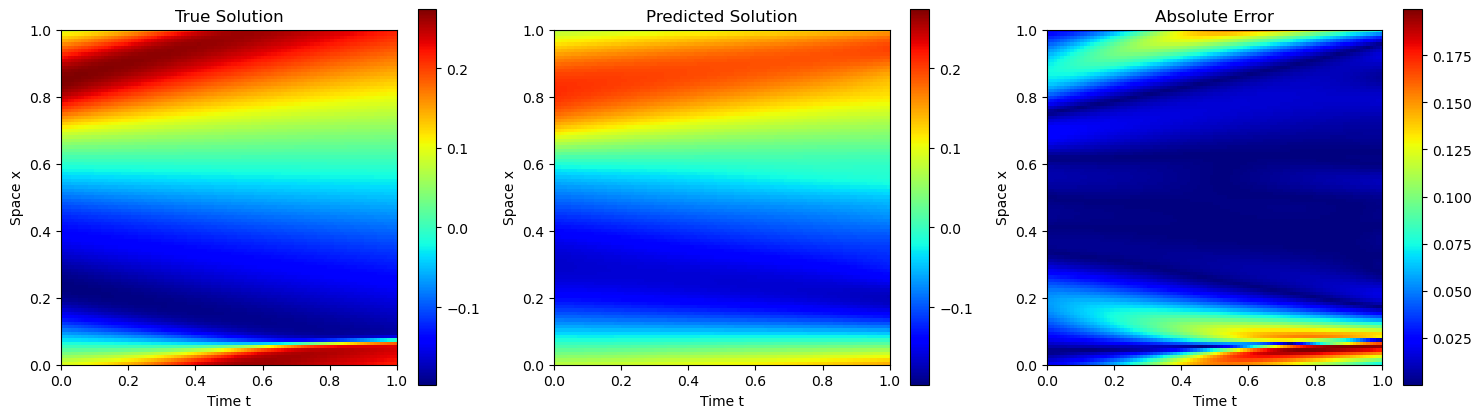


=== Test Sample 12 ===
Sample 12 Relative L2 Error: 4.185e-01


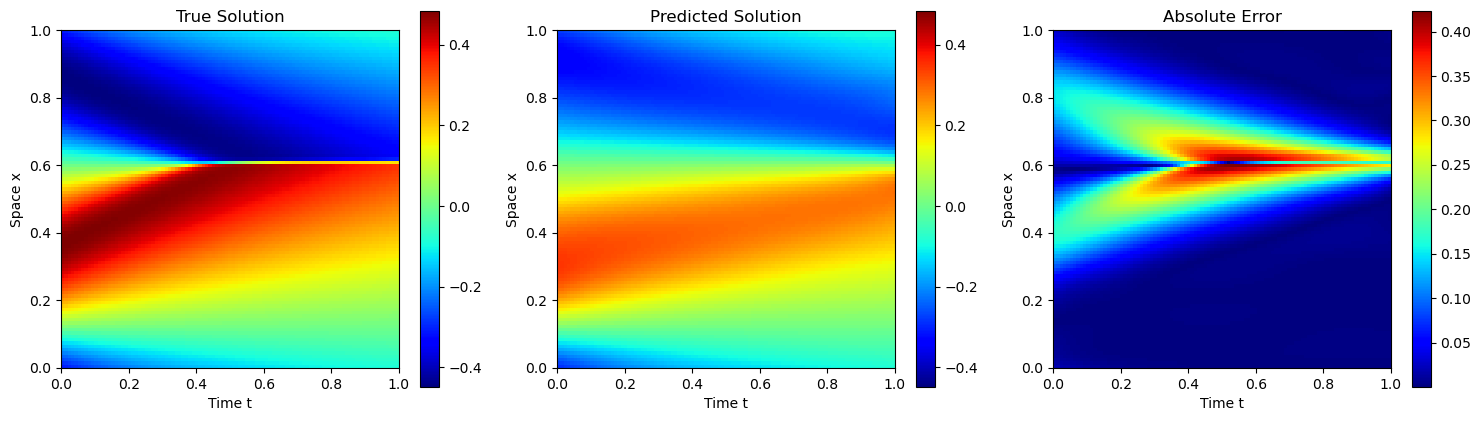


=== Test Sample 50 ===
Sample 50 Relative L2 Error: 2.964e-01


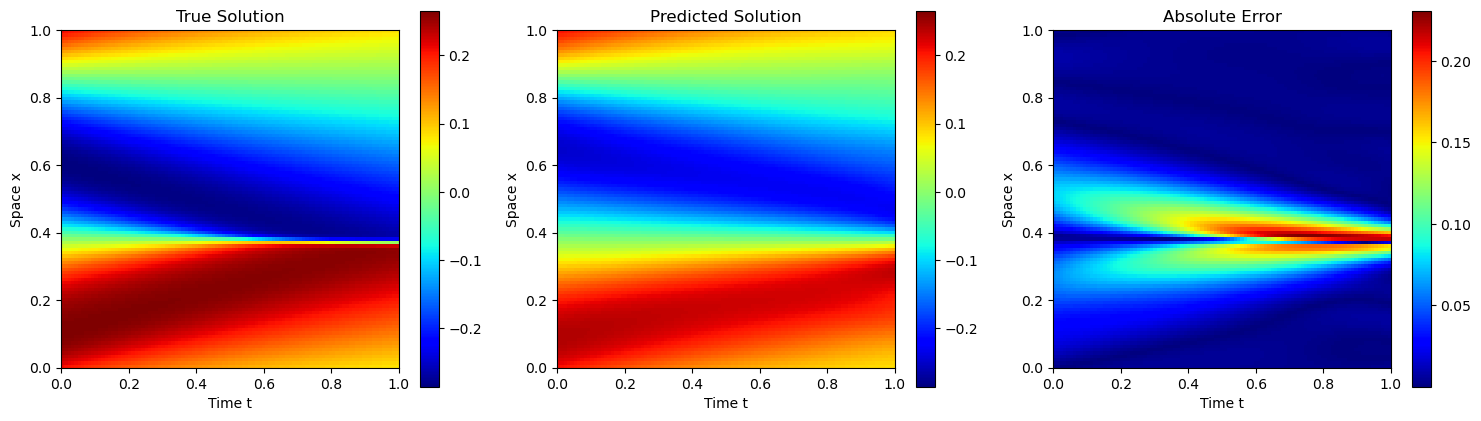

In [17]:
# Visualize prediction results for multiple test samples
sample_indices = [2, 4, 8, 10, 12, 50]

print("Generating prediction result visualizations...\n")

for idx in sample_indices:
    print(f"\n=== Test Sample {idx} ===")
    visualize_prediction_comparison(test_trainer, idx)

## 总结

本notebook成功实现了物理信息深度算子网络(PI-DeepONet)用于求解Burgers方程。主要特点包括：

### 模型架构
- **分支网络**: 处理初始条件函数，将101维输入映射到100维特征空间
- **主干网络**: 处理时空坐标，将2维时空点映射到100维特征空间
- **输出合成**: 通过点积操作将分支和主干网络输出结合

### 物理约束
- **Burgers方程残差**: $\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} = 0$
- **初始条件约束**: 确保在$t=0$时网络输出与给定初始条件一致
- **边界条件约束**: 实现周期性边界条件

### 训练策略
- **多项损失函数**: 平衡物理约束和数据拟合
- **自适应学习率**: 使用指数衰减调度器
- **批量训练**: 高效的小批量梯度下降

### 性能评估
- **相对L2误差**: 量化预测精度
- **可视化对比**: 直观展示预测效果
- **统计分析**: 全面评估模型泛化能力

该实现展示了物理信息神经网络在偏微分方程求解中的强大能力，为复杂流体力学问题提供了有效的数值求解方案。